# Baseline

## Import and Basic Setup


In [25]:
from google.colab import drive
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.gridspec as gridspec


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


drive.mount('/content/drive')
train_dir = '/content/drive/My Drive/CV_Project/datasets/train'
test_dir  = '/content/drive/My Drive/CV_Project/datasets/test'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Define Our Transforms

We want grayscale (1 channel) images of size 64x64, and keep the intensity range in [0, 255], so we apply the following transformations:
1. grayscale so that each image has shape (1,64,64)
2. resize to (64,64)
3. toTensor() wich gives a tensor in [0,1]
4. lambda(...) to multiply the values by 255 so that the range is [0,255]

In [26]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 255.0)
])

## Load Training and Test datasets
Load image datasets from two directories, one for training and the other for testing

In [27]:
train_dataset_full = torchvision.datasets.ImageFolder(
    root=train_dir,
    transform=transform
    )

test_dataset = torchvision.datasets.ImageFolder(
    root=test_dir,
    transform=transform
    )


## Visualizing dataset classes
We print class names, the total number of classes and their distribution across the training set

In [28]:
print("Classes: ", train_dataset_full.classes)
num_classes = len(train_dataset_full.classes)
print("Number of classes: ", num_classes)


class_counts = Counter(train_dataset_full.targets)
print("\nClass counts in the training set:")
for class_idx, class_name in enumerate(train_dataset_full.classes):
    print(f"{class_name}: {class_counts[class_idx]} images")

Classes:  ['Bedroom', 'Coast', 'Forest', 'Highway', 'Industrial', 'InsideCity', 'Kitchen', 'LivingRoom', 'Mountain', 'Office', 'OpenCountry', 'Store', 'Street', 'Suburb', 'TallBuilding']
Number of classes:  15

Class counts in the training set:
Bedroom: 100 images
Coast: 100 images
Forest: 100 images
Highway: 100 images
Industrial: 100 images
InsideCity: 100 images
Kitchen: 100 images
LivingRoom: 100 images
Mountain: 100 images
Office: 100 images
OpenCountry: 100 images
Store: 100 images
Street: 100 images
Suburb: 100 images
TallBuilding: 100 images


## Visualizing a Dataset Sample

torch.Size([1, 64, 64])
Bedroom


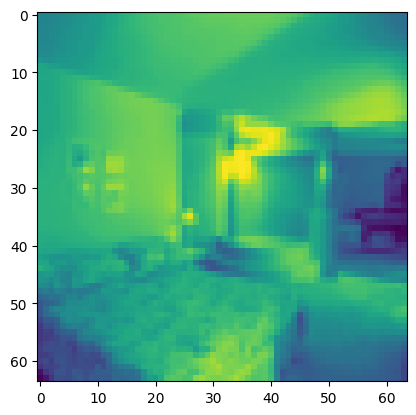

In [29]:
index = 24 # random index
img,label = train_dataset_full[index]

print(img.size())
print(train_dataset_full.classes[label])
figure = plt.figure()
plt.imshow(img.numpy().transpose((1,2,0)))

## Split the Training set into training and validation sets
Now we split the provided training set in 85% for actual training set and 15% to be used as validation set.

In [30]:
train_len = int(0.85 * len(train_dataset_full))
val_len   = len(train_dataset_full) - train_len

train_dataset, val_dataset = random_split(train_dataset_full, [train_len, val_len])

print("Training samples: ", len(train_dataset))
print("Validation samples:", len(val_dataset))

Training samples:  1275
Validation samples: 225


## Create dataloaders
Prepare DataLoaders for training, validation, and test datasets with optimization parameters for efficient data loading. Then prints the number of batches in each loader and verifies the size of a batch from the test_loader.

In [31]:
batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    prefetch_factor=4,
    persistent_workers=True
    )

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    prefetch_factor=4,
    persistent_workers=True
    )

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    prefetch_factor=4,
    persistent_workers=True
    )

print("Number of train batches:", len(train_loader))
print("Number of val   batches:", len(val_loader))
print("Number of test  batches:", len(test_loader))

for X, y in test_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break


Number of train batches: 40
Number of val   batches: 8
Number of test  batches: 94
Shape of X [N, C, H, W]: torch.Size([32, 1, 64, 64])
Shape of y: torch.Size([32]) torch.int64


## Batch Visualization with Class Labels


Labels:
Office | Suburb | OpenCountry | Suburb | Street | Coast | Kitchen | Office
Bedroom | OpenCountry | Suburb | OpenCountry | OpenCountry | TallBuilding | Street | Store
Industrial | OpenCountry | InsideCity | TallBuilding | Suburb | Forest | Suburb | Bedroom
Bedroom | Coast | Coast | Industrial | Suburb | Coast | Street | Bedroom



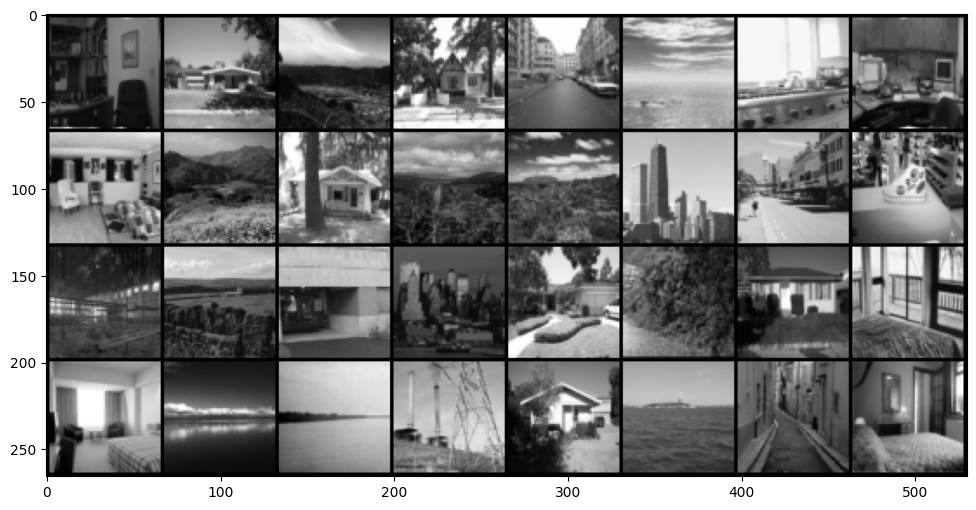

In [32]:
class_names = ['Bedroom', 'Coast', 'Forest', 'Highway', 'Industrial',
               'InsideCity', 'Kitchen', 'LivingRoom', 'Mountain',
               'Office', 'OpenCountry', 'Store', 'Street', 'Suburb', 'TallBuilding']



dataiter = iter(train_loader)
images, labels = next(dataiter)

dataiter = iter(train_loader)
images, labels = next(dataiter)

def show_images(images, labels, batch_size):

    label_names = [class_names[label] for label in labels]

    print("Labels:")
    for i in range(0, len(label_names), 8):  # Step size of 8
        print(" | ".join(label_names[i:i+8]))
    print()

    grid = torchvision.utils.make_grid(images, nrow=8, normalize=True)
    plt.figure(figsize=(12, 6))
    plt.imshow(grid.permute(1, 2, 0))
    plt.show()


show_images(images, labels, batch_size)


## Define the CNN Architecture

The CNN has the following layout:

| type                    | size                         |
|-------------------------|:-----------------------------|
|  Image Input            | 64×64×1 images               |
| Convolution             | 8 filters, 3×3, stride 1     |
| ReLU                    |                              |
| Max Pooling             | 2×2, stride 2                |
| Convolution             | 16 filters, 3×3, stride 1    |
| ReLU                    |                              |
| Max Pooling             | 2×2, stride 2                |
| Convolution             | 32 filters, 3×3, stride 1    |
| ReLU                    |                              |
| Fully Connected         | 15                           |
| Softmax                 | softmax                      |
| Classification Output   | crossentropy                 |


In [33]:
class ShallowCNN(nn.Module):
    def __init__(self, num_classes=15):
        super(ShallowCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()

        self.fc = nn.Linear(32 * 16 * 16, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = x.view(x.size(0), -1)

        x = self.fc(x)

        return x


## Initialize weights and biases
 * set the initial bias values to 0.
 * initialize weights from a Gaussian distribution with mean 0 and standard deviation 0.01.

In [34]:
def initialize_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0.0, std=0.01)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.0)

## Training loop and Evaluate on the Test Set
We will train for 30 epochs, tracking training / validation loss and accuracy, and implementing a simple early stopping criterion if validation loss fails to improve for 5 consecutive epochs (patience = 5).

We use **Stochastic Gradient Descent** (SGD) with momentum, batch size = 32 and perform **Hyperparameter tuning** for learning rate and momentum.

In [35]:
learning_rates = [1e-4, 1e-3, 1e-2]
momentums = [0.1, 0.5, 0.9]

results = []

for lr in learning_rates:
    for momentum in momentums:
        print(f"Starting training with learning rate: {lr}, momentum: {momentum}")
        print()

        model = ShallowCNN(num_classes=num_classes).to(device)
        model.apply(initialize_weights)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

        num_epochs = 30
        patience = 5
        best_val_loss = np.inf
        epochs_no_improve = 0

        train_losses = []
        val_losses = []
        train_accs = []
        val_accs = []

        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * images.size(0)

                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

            epoch_train_loss = running_loss / len(train_dataset_full)
            epoch_train_acc = 100.0 * correct / total

            train_losses.append(epoch_train_loss)
            train_accs.append(epoch_train_acc)


            model.eval()
            val_running_loss = 0.0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)

                    outputs = model(images)
                    loss = criterion(outputs, labels)

                    val_running_loss += loss.item() * images.size(0)

                    _, predicted = torch.max(outputs, 1)
                    val_correct += (predicted == labels).sum().item()
                    val_total += labels.size(0)

            epoch_val_loss = val_running_loss / len(val_dataset)
            epoch_val_acc = 100.0 * val_correct / val_total

            val_losses.append(epoch_val_loss)
            val_accs.append(epoch_val_acc)

            print(f"Epoch [{epoch+1}/{num_epochs}] "
                  f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}% || "
                  f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%")

            if epoch_val_loss < best_val_loss:
                best_val_loss = epoch_val_loss
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    print()
                    print("Early stopping triggered!")
                    break

        model.eval()
        test_correct = 0
        test_total = 0
        all_labels = []
        all_predictions = []

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                _, predicted = torch.max(outputs, 1)

                test_correct += (predicted == labels).sum().item()
                test_total += labels.size(0)

                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

        test_accuracy = 100.0 * test_correct / test_total
        print()
        print(f"Test Accuracy: {test_accuracy:.2f}%")
        print()
        print("----------------------------------------------------------------------------------------")
        print()

        results.append({
            'learning_rate': lr,
            'momentum': momentum,
            'test_accuracy': test_accuracy,
            'val_loss': best_val_loss,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accs': train_accs,
            'val_accs': val_accs,
            'all_labels': all_labels,
            'all_predictions': all_predictions
        })

results_df = pd.DataFrame(results)
best_result = max(results, key=lambda x: x['test_accuracy'])

print()
print("Hyperparameter tuning complete.")

Starting training with learning rate: 0.0001, momentum: 0.1

Epoch [1/30] Train Loss: 2.3016, Train Acc: 6.20% || Val Loss: 2.7077, Val Acc: 6.22%
Epoch [2/30] Train Loss: 2.3016, Train Acc: 6.12% || Val Loss: 2.7077, Val Acc: 6.22%
Epoch [3/30] Train Loss: 2.3015, Train Acc: 6.04% || Val Loss: 2.7077, Val Acc: 6.22%
Epoch [4/30] Train Loss: 2.3015, Train Acc: 6.27% || Val Loss: 2.7077, Val Acc: 6.22%
Epoch [5/30] Train Loss: 2.3015, Train Acc: 6.27% || Val Loss: 2.7076, Val Acc: 6.22%
Epoch [6/30] Train Loss: 2.3014, Train Acc: 6.27% || Val Loss: 2.7076, Val Acc: 6.67%
Epoch [7/30] Train Loss: 2.3014, Train Acc: 6.67% || Val Loss: 2.7076, Val Acc: 6.67%
Epoch [8/30] Train Loss: 2.3014, Train Acc: 6.75% || Val Loss: 2.7076, Val Acc: 6.67%
Epoch [9/30] Train Loss: 2.3014, Train Acc: 6.90% || Val Loss: 2.7076, Val Acc: 7.11%
Epoch [10/30] Train Loss: 2.3013, Train Acc: 6.90% || Val Loss: 2.7076, Val Acc: 7.11%
Epoch [11/30] Train Loss: 2.3013, Train Acc: 7.14% || Val Loss: 2.7076, Val Ac

## Plot of the results
We print the accuracy and validation loss obtained in each combination of parameters. Then we plot the confusion matrix, train/validation loss and training/validation accuracy during epochs for the best parameter combination, highlighting the best epoch (the one in which the validation loss was the lower)

   learning_rate  momentum  test_accuracy  val_loss
0         0.0001       0.1       4.589615  2.707167
1         0.0001       0.5      10.485762  2.707243
2         0.0001       0.9      18.123953  2.504374
3         0.0010       0.1      18.626466  2.484195
4         0.0010       0.5      25.561139  2.367784
5         0.0010       0.9      25.762144  2.455366
6         0.0100       0.1       8.576214  2.652479
7         0.0100       0.5       7.638191  2.669058
8         0.0100       0.9       7.202680  2.710053

Best Test Accuracy: 25.76%
Best Learning Rate: 0.001
Best Momentum: 0.9

Best epoch for validation loss: 12



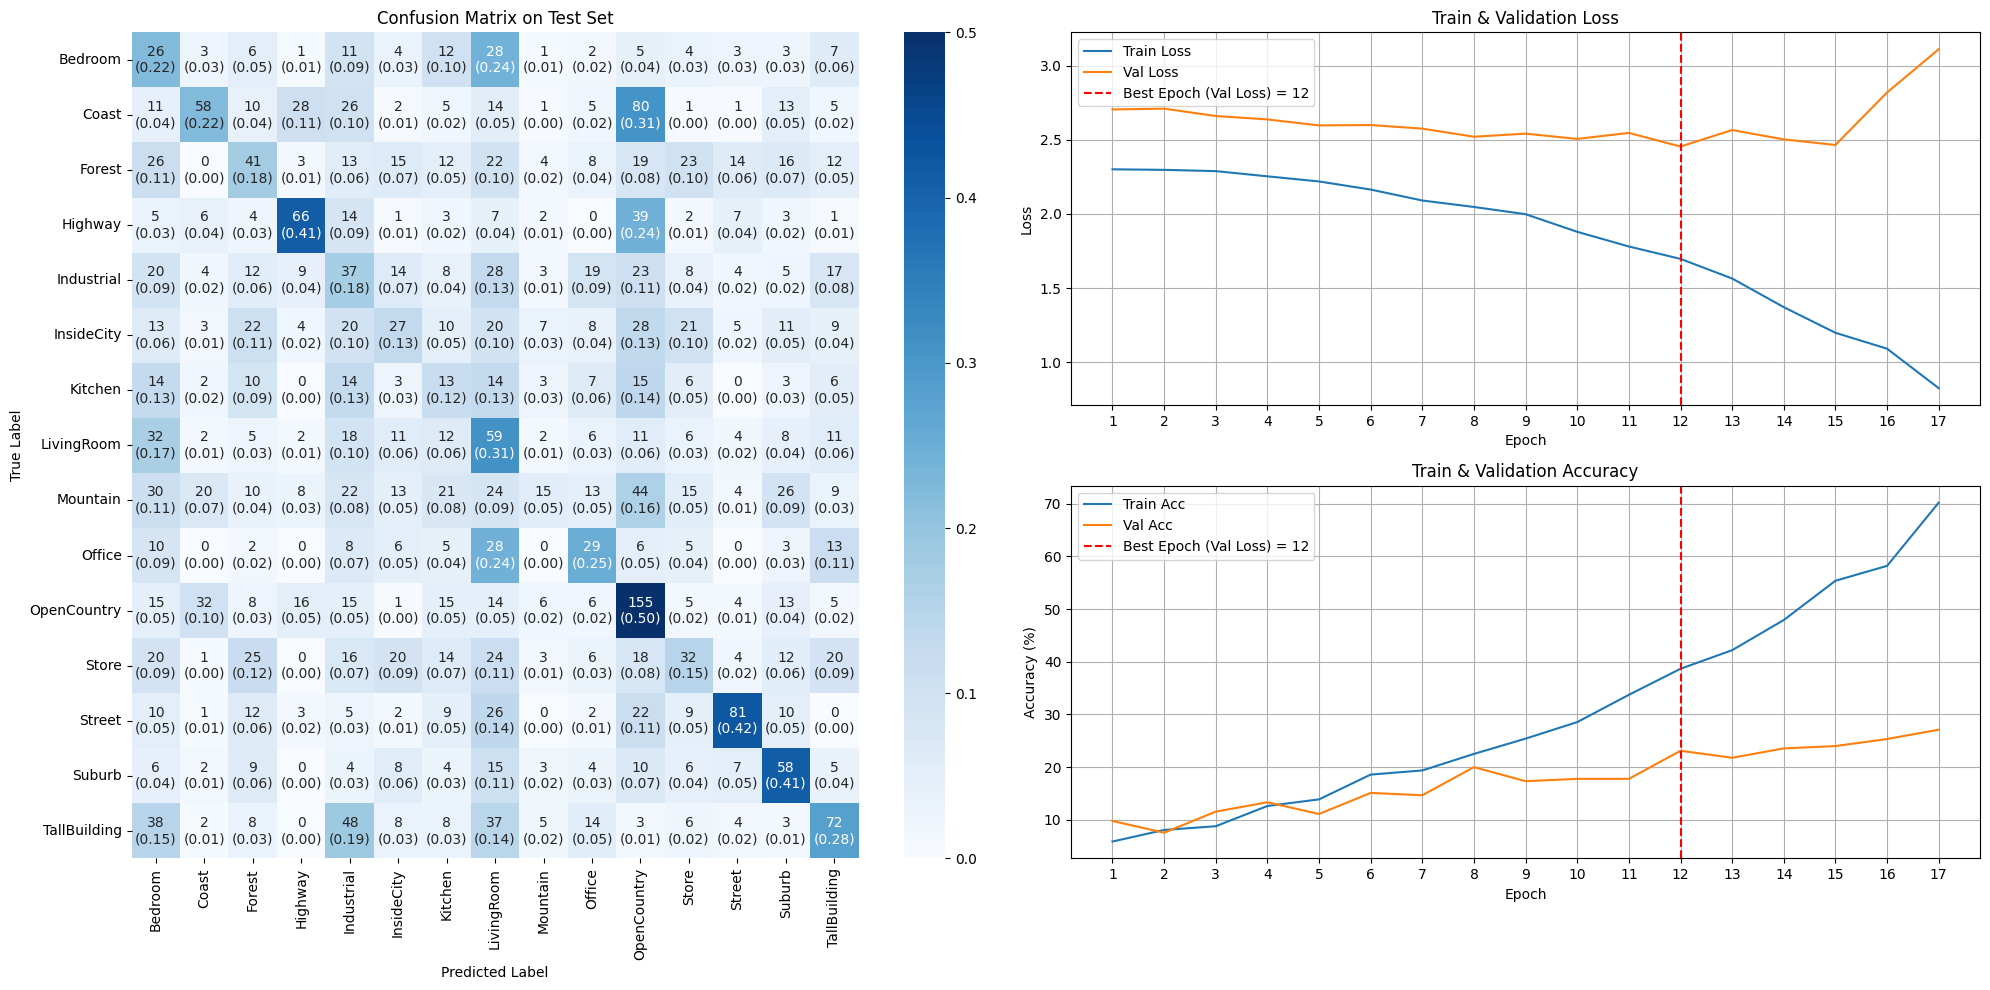

In [36]:
filtered_results = [
    {
        'learning_rate': result['learning_rate'],
        'momentum': result['momentum'],
        'test_accuracy': result['test_accuracy'],
        'val_loss': result['val_loss']
    }
    for result in results
]

filtered_results_df = pd.DataFrame(filtered_results)

print(filtered_results_df)
print()

print(f"Best Test Accuracy: {best_result['test_accuracy']:.2f}%")
print(f"Best Learning Rate: {best_result['learning_rate']}")
print(f"Best Momentum: {best_result['momentum']}")
print()

best_train_losses = best_result['train_losses']
best_val_losses = best_result['val_losses']
best_train_accs = best_result['train_accs']
best_val_accs = best_result['val_accs']
final_labels = best_result['all_labels']
final_predictions = best_result['all_predictions']
class_names = train_dataset_full.classes

best_epoch = np.argmin(best_val_losses)
print("Best epoch for validation loss:", best_epoch + 1)
print()


cm = confusion_matrix(final_labels, final_predictions)
row_sums = cm.sum(axis=1, keepdims=True)
normalized_cm = cm / row_sums

annot = np.empty(cm.shape, dtype=object)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        raw_count = cm[i, j]
        norm_val  = normalized_cm[i, j]
        annot[i, j] = f"{raw_count}\n({norm_val:.2f})"

class_names = test_dataset.classes


fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1])

ax_conf = fig.add_subplot(gs[:, 0])

ax_loss = fig.add_subplot(gs[0, 1])

ax_acc = fig.add_subplot(gs[1, 1])


sns.heatmap(
    normalized_cm,
    annot=annot,
    fmt='',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    ax=ax_conf
)
ax_conf.set_title("Confusion Matrix on Test Set")
ax_conf.set_xlabel("Predicted Label")
ax_conf.set_ylabel("True Label")


epochs = np.arange(1, len(best_train_losses) + 1)

ax_loss.plot(epochs, best_train_losses, label='Train Loss')
ax_loss.plot(epochs, best_val_losses, label='Val Loss')
ax_loss.axvline(x=best_epoch + 1, color='r', linestyle='--',
                label=f'Best Epoch (Val Loss) = {best_epoch + 1}')
ax_loss.set_xticks(epochs)
ax_loss.set_xticklabels(epochs)
ax_loss.set_xlabel('Epoch')
ax_loss.set_ylabel('Loss')
ax_loss.set_title('Train & Validation Loss')
ax_loss.legend()
ax_loss.grid(True)


ax_acc.plot(epochs, best_train_accs, label='Train Acc')
ax_acc.plot(epochs, best_val_accs, label='Val Acc')
ax_acc.axvline(x=best_epoch + 1, color='r', linestyle='--',
               label=f'Best Epoch (Val Loss) = {best_epoch + 1}')
ax_acc.set_xticks(epochs)
ax_acc.set_xticklabels(epochs)
ax_acc.set_xlabel('Epoch')
ax_acc.set_ylabel('Accuracy (%)')
ax_acc.set_title('Train & Validation Accuracy')
ax_acc.legend()
ax_acc.grid(True)

plt.tight_layout()
plt.show()